In [1]:
import pickle 
list_of_dags = pickle.load(open('data/unique_tasks.pkl', 'rb'))
print(f"Number of unique tasks: {len(list_of_dags)}")

Number of unique tasks: 665


In [2]:
import networkx as nx 
import matplotlib.pyplot as plt

list_of_unique_graphs = []

for dag in list_of_dags:
    G = nx.DiGraph()

    pos = dag['task_dag'].position
    # if 'Start' in pos: pos[0] = pos.pop('Start')
    # if 'Exit' in pos: pos[len(pos)] = pos.pop('Exit')

    for edge in dag['task_dag'].graph.edges:
        G.add_edge(edge[0], edge[1])

    for node in G.nodes:
        G.nodes[node]['pos'] = pos[node]
        G.nodes[node]['type'] = [1,0]
        G.nodes[node]['weight'] = 0

    list_of_unique_graphs.append(G)

print(f"Length of list of unique graphs: {len(list_of_unique_graphs)}")

def draw_graph(graph, show_node_label = False):
    figure = plt.figure(figsize=(10, 5))
    if not show_node_label:
        nx.draw(graph, pos=nx.get_node_attributes(graph, 'pos'), 
                with_labels= not show_node_label,  font_weight='bold', 
                node_color='skyblue', edge_color='gray', 
                node_size=800)

    else: 
        labels = nx.get_edge_attributes(graph, 'weight')

        color_map = []
        for node in graph:
            if graph.nodes[node]['type'] == [1,0]:
                color_map.append('skyblue')
            else:
                color_map.append('lightgreen')
        labels = nx.get_node_attributes(graph, 'weight')
        nx.draw_networkx_nodes(graph, pos=nx.get_node_attributes(graph, 'pos'), 
                                node_color=color_map, node_size=800)
        nx.draw_networkx_labels(graph, pos=nx.get_node_attributes(graph, 'pos'), labels=labels)
        nx.draw_networkx_edges(graph, pos=nx.get_node_attributes(graph, 'pos'), edge_color='gray', arrows=True)
    plt.show()


Length of list of unique graphs: 665


In [3]:
from tqdm import tqdm

list_of_graph_with_links = []

"""
Add a new node to the graph at the midpoint of each edge
"""
for G in tqdm(list_of_unique_graphs):
    G_copy = G.copy()
    edges = list(G.edges())
    for edge in edges:
        # Create a new node
        new_node = f"{edge[0]}_{edge[1]}"  # create a unique name for the new node

        # Calculate the position of the new node as the midpoint of the two nodes it's between
        pos1 = G.nodes[edge[0]]['pos']
        pos2 = G.nodes[edge[1]]['pos']
        new_pos = ((pos1[0] + pos2[0]) / 2, (pos1[1] + pos2[1]) / 2)

        # Remove the original edge first from the copy
        G_copy.remove_edge(*edge)

        # Add the new node to the graph copy with the calculated position
        G_copy.add_node(new_node, pos=new_pos, type=[0,1], weight=0)

        # Add two new edges to the copy
        G_copy.add_edge(edge[0], new_node)
        G_copy.add_edge(new_node, edge[1])

    # Now G_copy is the modified graph
    list_of_graph_with_links.append(G_copy)


100%|██████████| 665/665 [00:00<00:00, 5537.02it/s]


--------------Example One---------------- 


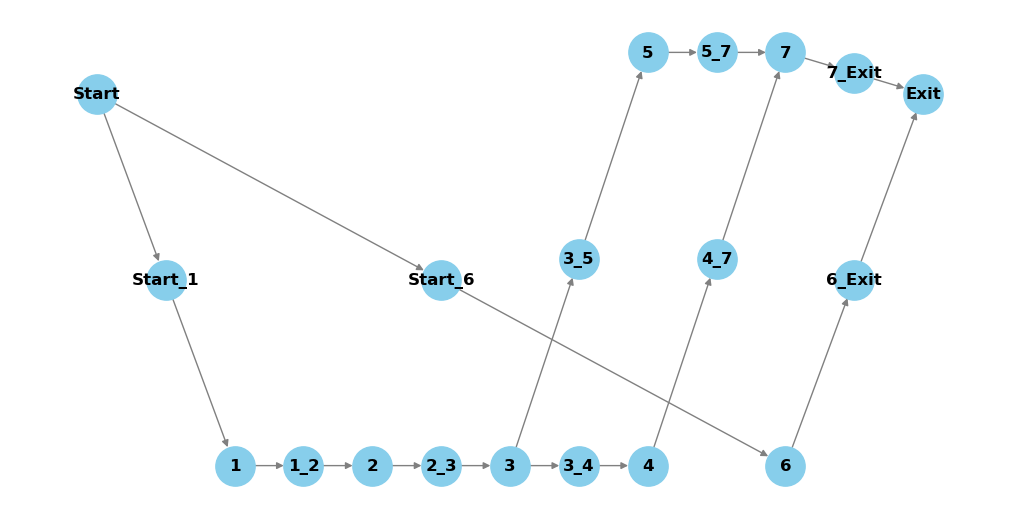

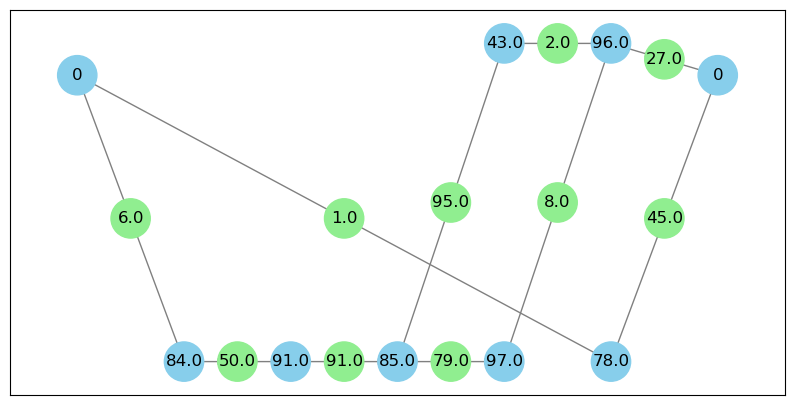

(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_5', 5, '5_7', 7, '7_Exit', 'Exit'], 670.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_4', 4, '4_7', 7, '7_Exit', 'Exit'], 714.0)
(['Start', 'Start_6', 6, '6_Exit', 'Exit'], 124.0)
Edges: 
tensor([[ 0,  1,  2,  2,  3,  4,  5,  7,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  1,  2,  3,  4,  5,  5,  6,  0,
          8,  6]])
Input feature is tensor([[0.8400, 1.0000, 0.0000],
        [0.9100, 1.0000, 0.0000],
        [0.8500, 1.0000, 0.0000],
        [0.4300, 1.0000, 0.0000],
        [0.9700, 1.0000, 0.0000],
        [0.9600, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.7800, 1.0000, 0.0000],
        [0.5000, 0.0000, 1.0000],
        [0.9100, 0.0000, 1.0000],
        [0.9500, 0.0000, 1.0000],
        [0.7900, 0.0000, 1.0000],
        [0.0200, 0.0000, 1.0000],
        [0.0800, 0.0000, 1.0000],
        [0.2700, 0.0000, 1.0000],

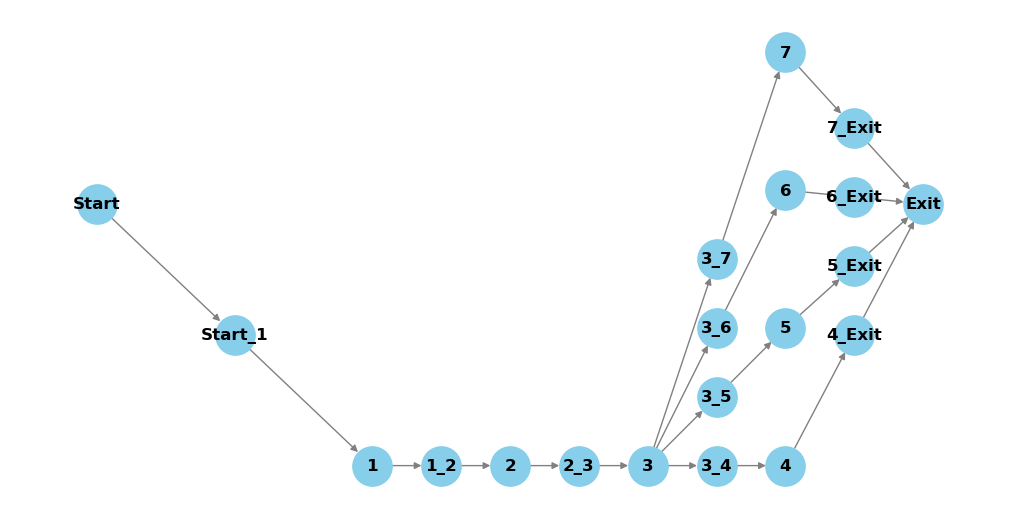

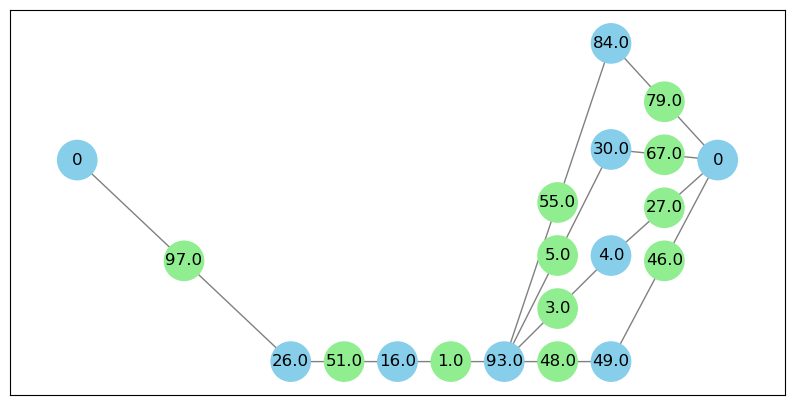

(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_6', 6, '6_Exit', 'Exit'], 386.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_7', 7, '7_Exit', 'Exit'], 502.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_5', 5, '5_Exit', 'Exit'], 318.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_4', 4, '4_Exit', 'Exit'], 427.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_6', 6, '6_Exit', 'Exit'], 386.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_7', 7, '7_Exit', 'Exit'], 502.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_5', 5, '5_Exit', 'Exit'], 318.0)
(['Start', 'Start_1', 1, '1_2', 2, '2_3', 3, '3_4', 4, '4_Exit', 'Exit'], 427.0)
Edges: 
tensor([[ 0,  1,  2,  2,  2,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  1,  2,  3,  4,  5,  6,  7,
          7,  7,  7,  0]])
Input feature is tensor([[0.2600, 1.0000, 0.0000],
        [0.1600, 1.0000, 0.0000],
        [0.9300, 1.0000, 0.0000],
        [0

In [4]:
import random 
import copy

dataset = []

random.seed(200)
"""For each unique dag, we create 10 samples"""
for G in list_of_graph_with_links:
    for i in range(10):
        for node in G:
            if node == 'Start' or node == 'Exit':
                continue
            G.nodes[node]['weight'] = float(random.randint(1, 100))
        dataset.append(copy.deepcopy(G))


def get_paths_duration(graph):
    paths = list(nx.all_simple_paths(graph, source='Start', target='Exit'))
    path_list_with_duration = []
    for path in paths: 
        duration = 0
        for node in path:
            duration += graph.nodes[node]['weight']
        path_list_with_duration.append((path, duration))

    return path_list_with_duration

import torch 
import torch_geometric.data as Data
from torch_geometric.utils import from_networkx

def convert_graph_to_tensor(graph, latency):
    graph_tensor = from_networkx(graph, group_node_attrs=['weight', 'type'])
    graph_tensor.y = torch.tensor([latency])
    graph_tensor.x[:, 0] = graph_tensor.x[:, 0] / 100
    del graph_tensor.pos
    return graph_tensor

print(f"--------------Example One---------------- ")
random_graph = list_of_graph_with_links[random.randint(0, len(list_of_graph_with_links))]
draw_graph(random_graph)
draw_graph(random_graph, show_node_label=True)

path_list = get_paths_duration(random_graph)
for item in path_list: print(item)
max_duration = max(path_list, key=lambda x: x[1])
graph_tensor = convert_graph_to_tensor(random_graph, max_duration[1] )

print(f"Edges: \n{graph_tensor.edge_index}")
print(f"Input feature is {graph_tensor.x}")
print(f"Latency is {graph_tensor.y}")

print(f"--------------Example Two---------------- ")
random_graph = list_of_graph_with_links[random.randint(0, len(list_of_graph_with_links))]
draw_graph(random_graph)
draw_graph(random_graph, show_node_label=True)
path_list= get_paths_duration(random_graph)
for item in path_list: print(item)
max_duration = max(path_list, key=lambda x: x[1])
convert_graph_to_tensor(random_graph, max_duration[1] )

path_list= get_paths_duration(random_graph)
for item in path_list: print(item)
max_duration = max(path_list, key=lambda x: x[1])
graph_tensor = convert_graph_to_tensor(random_graph, max_duration[1] )

print(f"Edges: \n{graph_tensor.edge_index}")
print(f"Input feature is {graph_tensor.x}")
print(f"Latency is {graph_tensor.y}")

Directory 'data/unique_graphs_with_links' already exists.


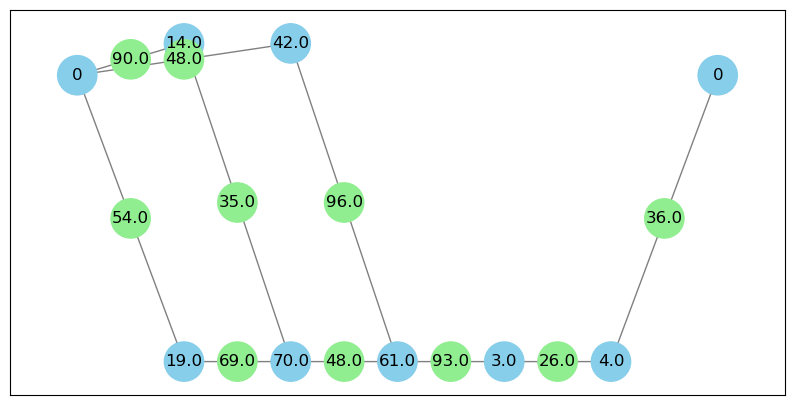

[(['Start', 'Start_1', 1, '1_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 483.0), (['Start', 'Start_2', 2, '2_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 480.0), (['Start', 'Start_4', 4, '4_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 409.0)]
Latency is 483.0


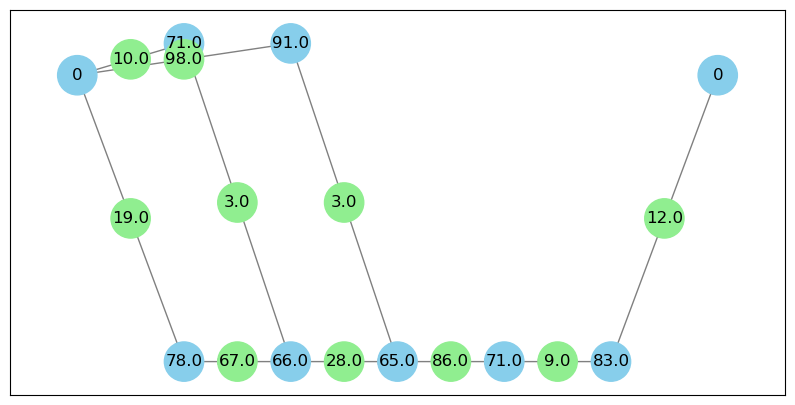

[(['Start', 'Start_1', 1, '1_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 584.0), (['Start', 'Start_2', 2, '2_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 504.0), (['Start', 'Start_4', 4, '4_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 518.0)]
Latency is 584.0


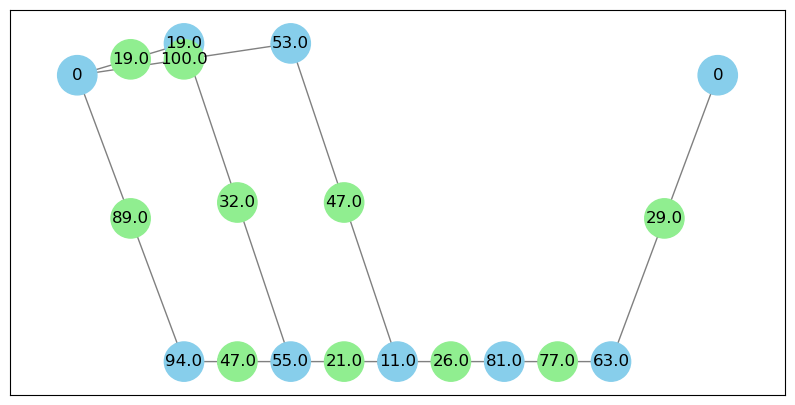

[(['Start', 'Start_1', 1, '1_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 593.0), (['Start', 'Start_2', 2, '2_3', 3, '3_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 433.0), (['Start', 'Start_4', 4, '4_5', 5, '5_6', 6, '6_7', 7, '7_Exit', 'Exit'], 487.0)]
Latency is 593.0


In [16]:
### Creating Dataset 

import os 

directory_path = 'data/unique_graphs_with_links'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

for idx, graph in enumerate(dataset):
    # print(f"Nodes: {graph.number_of_nodes()} and Edges: {graph.number_of_edges()}")
    # draw_graph(graph)
    # print(graph.nodes['1_3'])
    path_list = get_paths_duration(graph)
    max_duration = max(path_list, key=lambda x: x[1])

    graph_tensor = convert_graph_to_tensor(G, max_duration[1])
    

    start_index = 100
    if idx > start_index: 
        draw_graph(graph, show_node_label=True)
        print(f"Latency is {max_duration[1]}")

    if idx == start_index+3: break
    # torch.save(graph_tensor, f'{directory_path}/graph_{idx}.pt')
